# 3D Computer Vision - Exercise 4
FIRSTNAME LASTNAME

## Task 1. Corner detection (2 points).

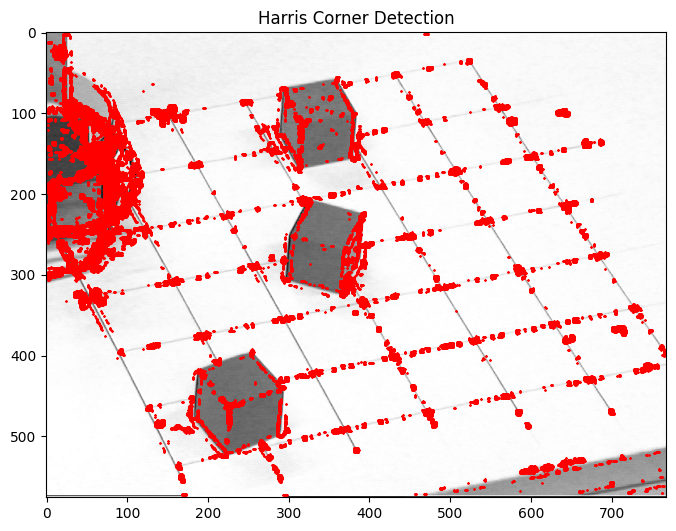

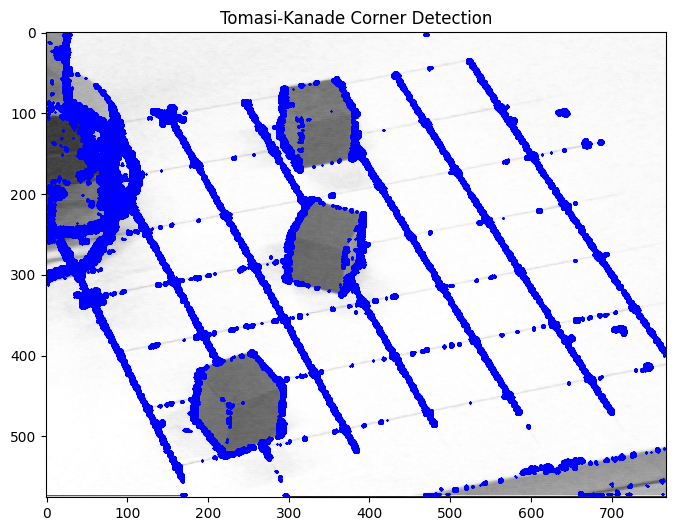

Comparison of R values between Harris and Tomasi-Kanade:
Metric                    Harris               Tomasi-Kanade
------------------------------------------------------------
Max R                     1233.030884          28.879133
Min R                     0.010001             0.100006
Mean R                    20.119232            1.044904

Top 5 corners detected (Harris):
  [ 3 27] -> R = 1233.030884
  [152 105] -> R = 1176.181030
  [136  95] -> R = 1155.900513
  [136  96] -> R = 1099.529663
  [169 111] -> R = 1056.772705

Top 5 corners detected (Tomasi-Kanade):
  [148  46] -> R = 28.879133
  [147  46] -> R = 28.529549
  [ 3 27] -> R = 27.671045
  [ 3 26] -> R = 27.602556
  [148  47] -> R = 26.636848


In [17]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def find_corners(img, N, t, k=None):
    """
    args:
        img: Input image, grayscale and float32 type.
        N: Size of the local neighborhood
        t: Threshold
        k: Harris detector parameter (if None, uses Tomasi-Kanade method)
    
    returns:
        corners: Array of detected corner coordinates (y, x)
        responses: Corresponding response values for each detected corner
        corner_response: Full response matrix
    """
    # Determine the method based on the value of k
    method = "Tomasi-Kanade" if k is None else "Harris"

    # Define Sobel kernels for computing image gradients
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    # Compute image gradients using convolution
    Ix = cv.filter2D(img, -1, kernel_x)
    Iy = cv.filter2D(img, -1, kernel_y)

    # Initialize a corner response map
    corner_response = np.zeros_like(img)
    
    row, col = img.shape
    for i in range(N, row - N):
        for j in range(N, col - N):
            # Compute structure tensor elements
            a = np.sum(Ix[i-N:i+N+1, j-N:j+N+1] ** 2)
            b = np.sum(Iy[i-N:i+N+1, j-N:j+N+1] ** 2)
            c = np.sum(Ix[i-N:i+N+1, j-N:j+N+1] * Iy[i-N:i+N+1, j-N:j+N+1])

            if method == "Tomasi-Kanade":
                # Compute eigenvalues and take the smaller one
                M = np.array([[a, c], [c, b]])
                eigenvalues = np.linalg.eigvalsh(M)
                response = min(eigenvalues)
            else:
                # Compute Harris corner measure
                det_T = (a * b) - (c ** 2)
                trace_T = a + b
                response = det_T - k * (trace_T ** 2)

            if response > t:
                corner_response[i, j] = response

    # Extract corner positions and responses
    corners = np.argwhere(corner_response > 0)
    responses = corner_response[corner_response > 0]

    # Sort by response strength (descending)
    sorted_indices = np.argsort(responses)[::-1]
    corners = corners[sorted_indices]
    responses = responses[sorted_indices]

    return corners, responses, corner_response

# Load image in grayscale and normalize
img = cv.imread("blocks_bw.png", cv.IMREAD_GRAYSCALE)
img = np.float32(img) / 255.0

# Parameters
N = 2
threshold_harris = 0.01
threshold_tomasi = 0.1
k = 0.04  # Harris detector parameter

# Compute Harris corners and response
harris_corners, harris_responses, harris_response_map = find_corners(img, N, threshold_harris, k=k)

# Compute Tomasi-Kanade corners and response
tomasi_corners, tomasi_responses, tomasi_response_map = find_corners(img, N, threshold_tomasi, k=None)

# Visualize detected corners (Harris)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.scatter(harris_corners[:, 1], harris_corners[:, 0], c='red', marker='*', s=1)
plt.title("Harris Corner Detection")
plt.show()

# Visualize detected corners (Tomasi-Kanade)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.scatter(tomasi_corners[:, 1], tomasi_corners[:, 0], c='blue', marker='x', s=1)
plt.title("Tomasi-Kanade Corner Detection")
plt.show()

# Print key statistics for comparison
print("Comparison of R values between Harris and Tomasi-Kanade:")
print(f"{'Metric':<25} {'Harris':<20} {'Tomasi-Kanade'}")
print("-" * 60)
print(f"{'Max R':<25} {np.max(harris_responses):<20.6f} {np.max(tomasi_responses):.6f}")
print(f"{'Min R':<25} {np.min(harris_responses):<20.6f} {np.min(tomasi_responses):.6f}")
print(f"{'Mean R':<25} {np.mean(harris_responses):<20.6f} {np.mean(tomasi_responses):.6f}")

# Print top detected corners with R values
print("\nTop 5 corners detected (Harris):")
for i in range(min(5, len(harris_corners))):
    print(f"  {harris_corners[i]} -> R = {harris_responses[i]:.6f}")

print("\nTop 5 corners detected (Tomasi-Kanade):")
for i in range(min(5, len(tomasi_corners))):
    print(f"  {tomasi_corners[i]} -> R = {tomasi_responses[i]:.6f}")


* The top 5 Harris corners have R values exceeding 1000, meaning it is very sensitive to high-intensity changes.
* Tomasi-Kanade detects corners with much smaller responses, making it better suited for stable, consistent corner selection.
* Harris detects stronger corners but is more sensitive to noise due to the large response values.
* Tomasi-Kanade is more stable and balanced, with smaller response values and a more uniform distribution.


## Task 2. Scale invariant interest points (2 points).

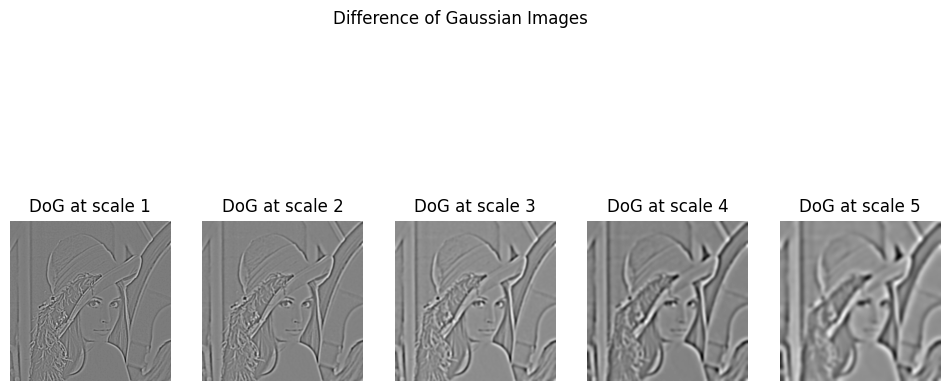

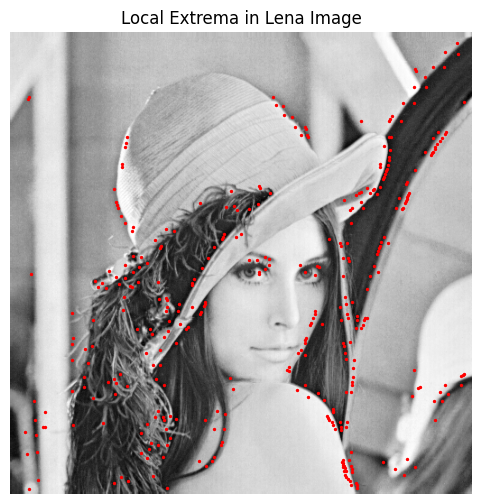

In [18]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def compute_DoG(img, sigma1=1.6, num_scales=5):
    """ Computes Difference of Gaussian (DoG) stack """
    sigmas = [sigma1 * (np.sqrt(2) ** i) for i in range(num_scales + 1)]
    blurred_imgs = [cv.GaussianBlur(img, (0, 0), sigma) for sigma in sigmas]
    
    # Compute DoG as the difference of adjacent scales
    DoG_stack = [blurred_imgs[i] - blurred_imgs[i + 1] for i in range(num_scales)]
    return np.stack(DoG_stack, axis=-1), sigmas[:-1]  # Return DoG stack and sigma values

def find_extremas(DoG_stack, threshold=0.03):
    """ Finds local extrema in DoG (26-neighbor comparison) """
    extrema = []
    rows, cols, scales = DoG_stack.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            for s in range(1, scales - 1):
                patch = DoG_stack[i - 1:i + 2, j - 1:j + 2, s - 1:s + 2]  
                center_val = DoG_stack[i, j, s]
                
                if np.abs(center_val) > threshold:
                    if center_val == np.max(patch) or center_val == np.min(patch):
                        extrema.append((i, j, s))

    return np.array(extrema)

def plot_DoG_images(DoG_stack, title):
    """ Plots the DoG images """
    num_images = DoG_stack.shape[-1]
    plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(DoG_stack[:, :, i], cmap='gray')
        plt.title(f"DoG at scale {i + 1}")
        plt.axis('off')
        
    plt.suptitle(title)
    plt.show()


def plot_extrema(img, extrema, title):
    """ Plots extrema points over an image """
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.scatter(extrema[:, 1], extrema[:, 0], c='r', s=2)  # x, y points
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load Lena grayscale image
img = cv.imread("lena_bw.png", cv.IMREAD_GRAYSCALE).astype(np.float64) / 255.0

# Step (a): Compute DoG
DoG_stack, sigmas = compute_DoG(img)
plot_DoG_images(DoG_stack, "Difference of Gaussian Images")

# Step (b): Find local extrema
extrema = find_extremas(DoG_stack)

# Step (c): Apply threshold and filter extrema
filtered_extrema = extrema 

# Step (d): Plot extrema on original Lena image
plot_extrema(img, filtered_extrema, "Local Extrema in Lena Image")



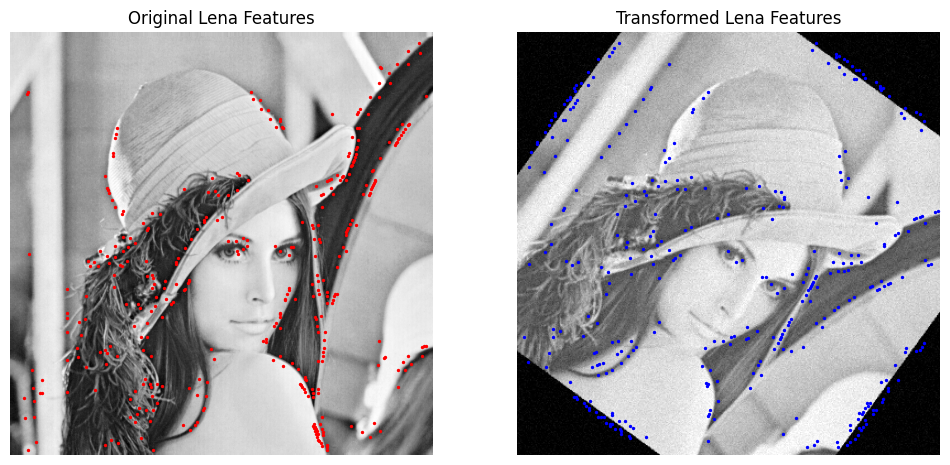

In [19]:
# Step (e): Repeat for Transformed Image
img_transformed = cv.imread("lena_bw_transformed.png", cv.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
DoG_stack_transformed, _ = compute_DoG(img_transformed)
extrema_transformed = find_extremas(DoG_stack_transformed)

# Plot both original and transformed results side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img, cmap='gray')
axes[0].scatter(filtered_extrema[:, 1], filtered_extrema[:, 0], c='r', s=2)
axes[0].set_title("Original Lena Features")
axes[0].axis('off')

axes[1].imshow(img_transformed, cmap='gray')
axes[1].scatter(extrema_transformed[:, 1], extrema_transformed[:, 0], c='b', s=2)
axes[1].set_title("Transformed Lena Features")
axes[1].axis('off')

plt.show()

#### - Are features from the transformed image different?

In [20]:
print(len(extrema_transformed))
print(len(extrema))

361
375


* The features are not the same
* There is a significant difference in the number of detected corners, and this shows that the transformation has affected feature detection.

### How can feature detection be improved?


* Reduce Noise with Preprocessing
    * Noise can create false corners or weaken real ones. Apply a Gaussian filter before computing gradients can help.

* Use Adaptive Thresholding
    * Instead of using a fixed threshold, adapt it based on image statistics